In [ ]:
import tensorflow as tf
import os
import time
from matplotlib import pyplot as plt

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aayushkakade","key":"dcaecf46d1b093847608a2703cc2ab93"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-06-01 11:18:46           6800  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           4035  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1357  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           2117  
mathurinache/twitter-edge-nodes                             Twitter Edge Nod

In [ ]:
! kaggle datasets download -d ktaebum/anime-sketch-colorization-pair


100% 11.6G/11.6G [04:41<00:00, 18.8MB/s]



In [ ]:
! unzip anime-sketch-colorization-pair.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/data/train/2906115.png  
  inflating: train/data/train/2906116.png  
  inflating: train/data/train/2906119.png  
  inflating: train/data/train/2906139.png  
  inflating: train/data/train/2906140.png  
  inflating: train/data/train/2906141.png  
  inflating: train/data/train/2906143.png  
  inflating: train/data/train/2907043.png  
  inflating: train/data/train/2907052.png  
  inflating: train/data/train/2907059.png  
  inflating: train/data/train/2907062.png  
  inflating: train/data/train/2907075.png  
  inflating: train/data/train/2907105.png  
  inflating: train/data/train/2907107.png  
  inflating: train/data/train/2907108.png  
  inflating: train/data/train/2907113.png  
  inflating: train/data/train/2907130.png  
  inflating: train/data/train/2907138.png  
  inflating: train/data/train/2907144.png  
  inflating: train/data/train/2907146.png  
  inflating: train/data/train/2907148.png  
  inflating: train/data/t

In [ ]:
PATH = '/content/train/data'

In [ ]:
EPOCHS = 100
BUFFER_SIZE = 1500
BATCH_SIZE = 2
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def process(imagefile):
  image = tf.io.read_file(imagefile)
  image = tf.image.decode_png(image)

  s = tf.shape(image)[1]
  s= s // 2

  real = image[:, :s, :]
  input = image[:, s:, :]

  real = tf.cast(real, tf.float32)
  input = tf.cast(input, tf.float32)

  return input, real

In [ ]:
def resize(input, real, h, w):
  input = tf.image.resize(input, [h,w], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real = tf.image.resize(real, [h,w], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input, real

In [ ]:
def random_crop(input,real):
  stacked = tf.stack([input,real],axis=0)
  cropped = tf.image.random_crop(stacked,size=[2,IMG_HEIGHT,IMG_WIDTH,3])
  return cropped[0],cropped[1]

In [ ]:
def normalize(input,real):
  input = (input/127.5) - 1
  real = (real/127.5)-1
  return input,real

In [ ]:
@tf.function()
def jitter(input,real):
  input, real = resize(input, real, 286, 286)
  input, real = random_crop(input, real)

  if tf.random.uniform(())>0.5:
    input = tf.image.flip_left_right(input)
    real = tf.image.flip_left_right(real)
  
  return input, real

In [ ]:
def train_image(imagefile):
    input, real = process(imagefile)
    input, real = jitter(input, real)
    input, real = normalize(input, real)

    return input, real
    
train_dataset = tf.data.Dataset.list_files(PATH+'/train/*.png')
train_dataset = train_dataset.map(train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def test_image(imagefile):
  input,real = process(imagefile)
  input,real = resize(input,real,IMG_HEIGHT,IMG_WIDTH)
  input, real = normalize(input,real)

  return input,real

test_dataset = tf.data.Dataset.list_files(PATH+'/val/*.png')
test_dataset = test_dataset.map(test_image)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
OUTPUT_CHANNELS=3

def downsample(filters,size,shape, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0.,0.02)
  result = tf.keras.Sequential(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', batch_input_shape=shape, kernel_initializer=initializer, use_bias=False)
  )
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.LeakyReLU())
  return result



In [ ]:
def upsample(filters, size, shape, apply_dropout=False):
  initializer = tf.random_normal_initializer(0.,0.02)
  result = tf.keras.Sequential(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2, batch_input_shape=shape, padding='same', kernel_initializer=initializer, use_bias=False)
  )
  result.add(tf.keras.layers.BatchNormalization())
  
  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))
  
  result.add(tf.keras.layers.ReLU())
  return result

In [ ]:
def generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
                downsample(64,4,(None,256,256,3),apply_batchnorm=False),
                downsample(128,4,(None,128,128,64)),
                downsample(256,4,(None,64,64,128)),
                downsample(512,4,(None,32,32,256)),
                downsample(512,4,(None,16,16,512)),
                downsample(512,4,(None,8,8,512)),
                downsample(512,4,(None,4,4,512)),
                downsample(512,4,(None,2,2,512))
  ]
  up_stack = [
              upsample(512,4,(None,1,1,512),apply_dropout=True),
              upsample(512,4,(None,2,2,1024),apply_dropout=True),
              upsample(512,4,(None,4,4,1024),apply_dropout=True),
              upsample(512,4,(None,8,8,1024)),
              upsample(256,4,(None,16,16,1024)),
              upsample(128,4,(None,32,32,512)),
              upsample(64,4,(None,64,64,256))
  ]
  initializer = tf.random_normal_initializer(0.,0.02)

  final = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')

  x = inputs

  skips=[]
  for down in down_stack:
    x=down(x)
    skips.append(x)
  
  skips = reversed(skips[:-1])

  for up,skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.concatenate([x, skip])

  x = final(x)
  return tf.keras.Model(inputs=inputs,outputs=x)

generator = generator()

In [ ]:
def downs(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0.,0.02)

  result = tf.keras.Sequential(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)
  )

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  
  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
def discriminator():
  initializer = tf.random_normal_initializer(0.,0.02)

  input = tf.keras.layers.Input(shape=[256,256,3], name='input')
  target = tf.keras.layers.Input(shape=[256,256,3], name='target')

  x = tf.keras.layers.concatenate([input,target])

  down1 = downs(64,4,False)(x)
  down2 = downs(128,4)(down1)
  down3 = downs(256,4)(down2)

  zeropad1 = tf.keras.layers.ZeroPadding2D()(down3)
  conv = tf.keras.layers.Conv2D(512,4,strides=1,kernel_initializer=initializer,use_bias=False)(zeropad1)
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
  relu = tf.keras.layers.LeakyReLU()(batchnorm1)
  zeropad2 = tf.keras.layers.ZeroPadding2D()(relu)
  final = tf.keras.layers.Conv2D(1,4,strides=1,kernel_initializer=initializer)(zeropad2)

  return tf.keras.Model(inputs = [input,target], outputs=final)

discriminator = discriminator()

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

l=100

def generator_loss(disc_output,output,target):
  gan_loss = loss(tf.ones_like(disc_output),disc_output)
  l1_loss = tf.reduce_mean(tf.abs(target - output))
  total_gen_loss = gan_loss + l*l1_loss

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output,disc_gen_output):
  real_loss = loss(tf.ones_like(disc_real_output),disc_real_output)
  generated_loss = loss(tf.zeros_like(disc_gen_output),disc_gen_output)
  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
gen_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

In [ ]:
checkpoint_dir = './Sketch2Color_training_checkponts'
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer, discriminator_optimizer=disc_optimizer, generator=generator, discriminator=discriminator)

In [ ]:
def generate_images(model,test_input,target):
  pred = model(test_input, training=True)
  plt.figure(figsize=(15,15))
  display_list = [test_input[0], target[0], pred[0]]
  title = ['input','real','predicted']
  for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
  plt.show()

In [ ]:
import datetime
log_dir = "Sketch2Coloe_logs"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d - %H%M%S"))

In [ ]:
@tf.function
def train_step(input, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input, training=True)

    disc_real_output = discriminator([input,target], training=True)
    disc_gen_output = discriminator([input,gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_gen_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output,disc_gen_output)

  gen_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
  disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  gen_optimizer.apply_gradients(zip(gen_gradients,generator.trainable_variables))
  disc_optimizer.apply_gradients(zip(disc_gradients,
                                              discriminator.trainable_variables))
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss',gen_total_loss,step=epoch)
    tf.summary.scalar('gen_gan_loss',gen_gan_loss,step=epoch)
    tf.summary.scalar('gen_l1_loss',gen_l1_loss,step=epoch)
    tf.summary.scalar('disc_loss',disc_loss,step=epoch)

In [ ]:
def fit(train_data,epochs,test_data):
  for epoch in range(epochs):
    start=time.time()
    
    for example_input, example_target in test_data.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    for n, (input,target) in train_data.enumerate():
      print('.',end='')
      if (n+1)%100 == 0:
        print()
      train_step(input,target,epoch)
    print()

    if (epoch+1)%10==0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print('Time taken for epoch {} is {} sec\n'.format(epoch+1,time.time()-start))

  checkpoint.save(file_prefix = checkpoint_prefix)

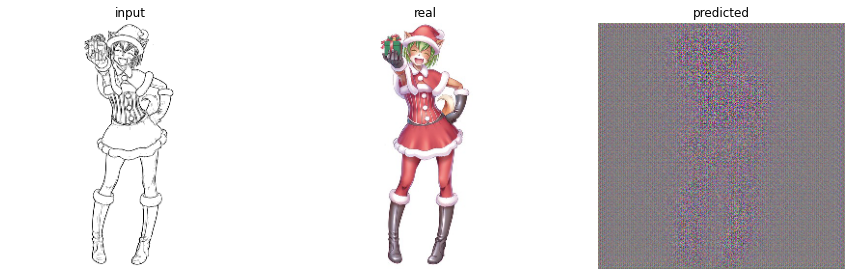

Epoch:  0
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

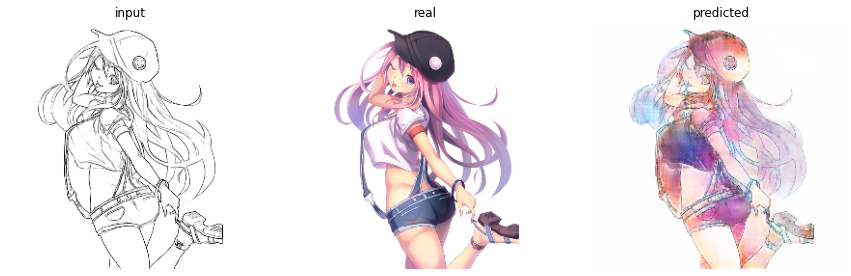

Epoch:  1
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

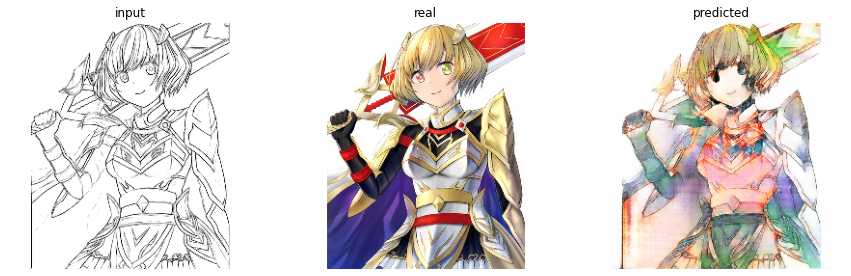

Epoch:  2
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

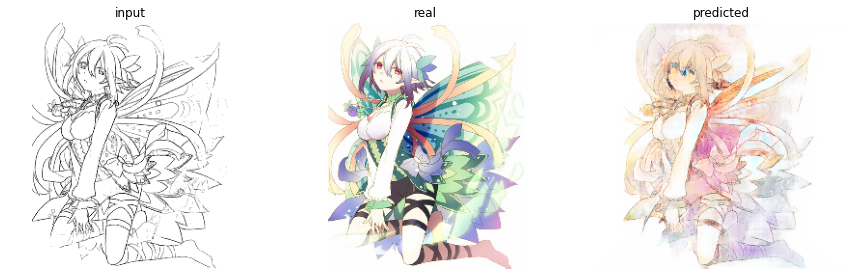

Epoch:  3
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

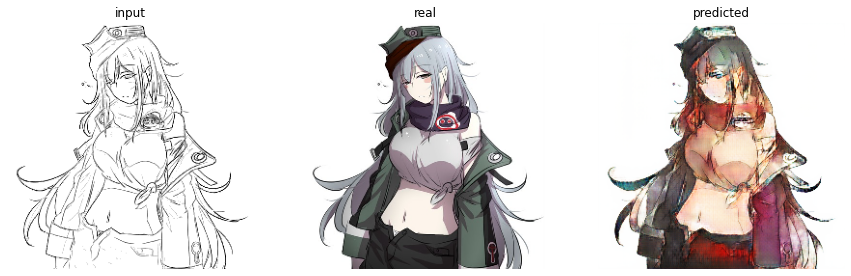

Epoch:  4
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

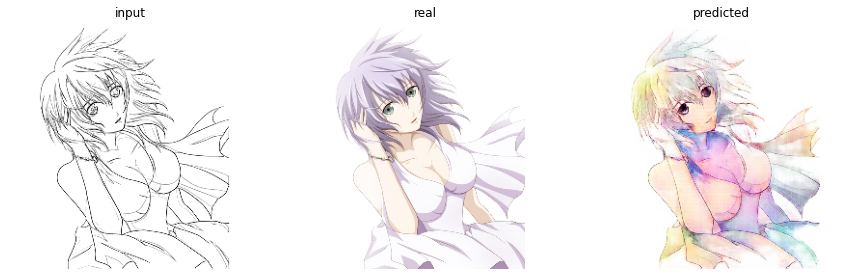

Epoch:  5
...............................................

KeyboardInterrupt: ignored

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
for ex_in,ex_tar in test_database.take(1):
  generate_images(generator,ex_in,ex_tar)

In [ ]:
generator.save("CGAN Assignment")